In [1]:
import torch
import librosa
import IPython.display as ipd
from ddsp.core import extract_loudness, extract_pitch
import numpy as np
from os import makedirs, path
import pretty_midi
from matplotlib import pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import math

In [2]:
PHONEMES = ['sil', 'b','d','f','g','h','j','k','l','m','n','p','r','s','t','v','w','z','zh','ch','sh','th','dh','ng','y','ae','ei','e','ii','i','ai','a','ou','u','ao','uu','oi','au','eo','er','oo']
PHONEME2ID={}
for i,p in enumerate(PHONEMES):
    PHONEME2ID[p] = i

In [3]:
MODEL_PATH = "export/ddsp_train_phonemes_fixed_pretrained.ts"
SAMPLE_RATE = 16000
SIGNAL_LENGTH = 128000
BLOCK_SIZE = 128

In [4]:
model = torch.jit.load(MODEL_PATH)

## Resynthesize training data

In [ ]:
ipd.Audio("../CSD/english/wav/en001a.wav")

In [ ]:
signals = np.load(path.join("preprocessed", "signals.npy"))
pitches = np.load(path.join("preprocessed", "pitchs.npy"))
loudness = np.load(path.join("preprocessed", "loudness.npy"))
phonemes = np.load(path.join("preprocessed", "phonemes.npy"))

In [ ]:
idx = 10
p = pitches[idx].reshape((1,-1,1))
l = loudness[idx].reshape((1,-1,1))
pho = phonemes[idx].reshape((1,-1,1))

In [ ]:
plt.plot(l.flatten())

In [ ]:
plt.plot(p.flatten())

In [ ]:
audio = model(torch.from_numpy(p), torch.from_numpy(l), torch.from_numpy(pho))
audio_np = audio.detach().numpy().flatten()
samples = audio_np.shape[0]
length_sec = samples / SAMPLE_RATE
print("{} samples, {} seconds".format(samples, length_sec))
ipd.Audio(audio_np, rate=SAMPLE_RATE)

## Timbre Transfer, unseen data

In [9]:
TEST_FILE = "audio.wav"
PHONEMES_FILE = "phonemes.txt"
MIDI_FILE = "test.mid"

In [10]:
full_data,sr = librosa.load(TEST_FILE, sr=SAMPLE_RATE)
ipd.Audio(full_data, rate=SAMPLE_RATE)

In [11]:
def alignPhonemesToMidi(phonemes_file, midi_file, audio_length):
    with open(phonemes_file) as f:
        lines = f.readlines()
    phonemes_data = lines[0]
    
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    midi_notes = midi_data.instruments[0].notes
    syllables = phonemes_data.split(" ")
    assert(len(midi_notes) == len(syllables))

    #label_length = int(SIGNAL_LENGTH / BLOCK_SIZE)
    label_length = audio_length
    phoneme_labels = np.zeros(label_length)
    tpb = BLOCK_SIZE * 1.0 / SAMPLE_RATE
    cb = math.ceil(.05 / tpb)
    for i, midi in enumerate(midi_notes):
        start_frame = math.floor(midi.start * float(SAMPLE_RATE) / float(BLOCK_SIZE))
        end_frame = math.ceil(midi.end * float(SAMPLE_RATE) / float(BLOCK_SIZE))

        phonemes = syllables[i].split("_")
        N = len(phonemes)
        duration = (end_frame - start_frame)
        durations = np.zeros(N, dtype='int32')
        for i, pho in enumerate(phonemes):
            if(PHONEME2ID[pho] < PHONEME2ID['ae']):
                durations[i] = cb
        total_const_time = np.sum(durations)
        n_const = total_const_time / cb
        n_vowel = N - n_const
        N_per_vowel = (duration - total_const_time) / n_vowel
        for i, pho in enumerate(phonemes):
            if(PHONEME2ID[pho] >= PHONEME2ID['ae']):
                durations[i] = N_per_vowel
        idx = start_frame
        for i, pho in enumerate(phonemes):
            phoneme_labels[idx:(idx + durations[i])] = PHONEME2ID[pho]
            idx += durations[i]
            
    return phoneme_labels

def constructLoudness(midi_file, audio_length, spacing=0.05, noise=0.2):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    midi_notes = midi_data.instruments[0].notes
    
    times = np.zeros(len(midi_notes) * 2)
    for i, midi in enumerate(midi_notes):
        times[2 * i] = midi.start
        times[2 * i + 1] = midi.end - spacing
    time_samps = (times * SAMPLE_RATE / BLOCK_SIZE).astype('int32')
    
    onsets = np.random.default_rng().uniform(-3.0, -2.0, len(midi_notes))
    offsets = np.random.default_rng().uniform(-6.0, -4.5, len(midi_notes))
    loudness_pts = np.zeros(len(midi_notes) * 2)
    for i in range(len(midi_notes)):
        loudness_pts[2*i] = onsets[i]
        loudness_pts[2*i + 1] = offsets[i]
    
    #size = np.max([SIGNAL_LENGTH // BLOCK_SIZE, time_samps[len(time_samps) - 1]])
    #loudness = np.zeros(size)
    loudness = np.zeros(audio_length)
    for i in range(len(time_samps) - 1):
        duration = time_samps[i+1] - time_samps[i]
        loudness[time_samps[i]:time_samps[i+1]] = np.linspace(loudness_pts[i], loudness_pts[i + 1], num=duration)
    loudness[time_samps[len(time_samps)-1]::] = loudness_pts[len(loudness_pts)-1]
    
    loudness = loudness + np.random.default_rng().uniform(-1.0 * noise, noise, len(loudness))
    
    return loudness

def createVocals(test_file, phonemes_file, midi_file):
    full_data,sr = librosa.load(test_file, sr=SAMPLE_RATE)
    audio_length = len(full_data) // BLOCK_SIZE
    phoneme_labels = alignPhonemesToMidi(phonemes_file, midi_file, audio_length)
    loudness = constructLoudness(midi_file, audio_length)
    pitch = extract_pitch(full_data, SAMPLE_RATE, BLOCK_SIZE)

def createVocals(test_file, phonemes_file, midi_file):
    full_data,sr = librosa.load(test_file, sr=SAMPLE_RATE)
    audio_length = len(full_data) // BLOCK_SIZE
    phoneme_labels = alignPhonemesToMidi(phonemes_file, midi_file, audio_length)
    loudness = constructLoudness(midi_file, audio_length)
    pitch = extract_pitch(full_data, SAMPLE_RATE, BLOCK_SIZE)
    
    segment_len = SIGNAL_LENGTH // BLOCK_SIZE
    num_segments = math.ceil(audio_length * 1.0 / segment_len)
    final_audio = np.array([])
    for i in range(num_segments):
        s = i * segment_len
        e = i * segment_len + segment_len
        p = pitch[s:e].reshape((1,-1,1)).astype('float32')
        l = loudness[s:e].reshape((1,-1,1)).astype('float32')
        pho = phoneme_labels[s:e].reshape((1,-1,1)).astype('int32')
        audio_out = model(torch.from_numpy(p), torch.from_numpy(l), torch.from_numpy(pho))
        final_audio = np.append(final_audio, audio_out.detach().numpy().flatten())

    print("Generated {} samples, {} seconds".format(final_audio.shape[0], final_audio.shape[0] / SAMPLE_RATE))
    return final_audio

In [12]:
audio_length = len(full_data) // BLOCK_SIZE
phoneme_labels = alignPhonemesToMidi(PHONEMES_FILE, MIDI_FILE, audio_length)
loudness = constructLoudness(MIDI_FILE, audio_length)
pitch = extract_pitch(full_data, SAMPLE_RATE, BLOCK_SIZE)

47/47 [==============================] - 3s 12ms/step


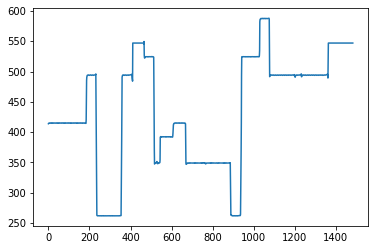

In [13]:
plt.plot(pitch)

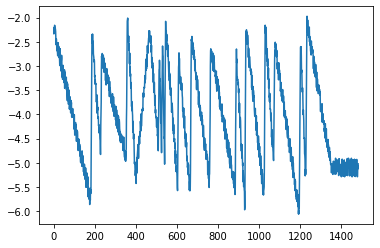

In [14]:
plt.plot(loudness)

In [15]:
output = createVocals(TEST_FILE, PHONEMES_FILE, MIDI_FILE)
ipd.Audio(output, rate=SAMPLE_RATE)

47/47 [==============================] - 0s 9ms/step
Generated 189952 samples, 11.872 seconds
